In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import matplotlib.pyplot as plt

In [6]:
class PopulationEvolution:
    def __init__(self, population_size = 100, top_k = 20, main_genotype_length = 1, meta_level = 3, meta_initialization = 0.1, meta_mutation_rate = 0.1, nr_of_generations = 2000, referential = False, elitism = True, value = 1, mutation_type = 2, verbose = False):        
        """
        Initialize the parameters.

        Parameters:
        -----------
        population_size : int, default=100
            The size of the population. Must be >=1.
        
        top_k : int, default=20
            The number of top individuals selected for reproduction. Must be >= 1 and <= population_size.

        main_genotype_length : int, default=1
            The length of the main part of the genotype (the part of the genome that does not contain meta-parameters), i.e., the part representing the solution.

        meta_level : int, default=3
            The number of metaparameters for the individuals from the population. Must be >= 0.

        meta_initialization : float, default=0.1
            Initialization value for the metaparameters. (All metaparameters are initialized to the same value.) Must be > 0.

        meta_mutation_rate : float, default=0.1
            Must be > 0. If regular meta-mutation scheme is used, this is the (external) meta mutation rate for the individuals from the population. In that case, it is used only if self-referential mutations rates are inactive (referential == False).
            If additive meta-mutation scheme is used instead, this is effectively the noise parameter, as in "Arbitrary Order Meta-Learning with Simple Population-Based Evolution" by Lu et al., 2023.

        nr_of_generations : int, default=2000
            The number of generations for the algorithm to run.

        referential : bool, default=False
            Whether or not to use the self-referential top meta-mutation rate. 

        elitism : bool, default=True
            If True, retains a certain number of top-performing individuals in each generation.

        value : float, default=0.5
            The value of the auctioned item. Should be positive.

        mutation_type: int, default=1
            The type of meta-mutation scheme used - regular (1) or additive (2).

        verbose: bool, default=False,
            Prints additional info (population members) every 100 generations.

        Raises:
        -------
        ValueError:
            If any of the input parameters do not meet the constraints mentioned above.

        """
        if population_size < 1:
            raise ValueError("Invalid population size, should be >=1")
        if (top_k < 1) or (top_k > population_size):
            raise ValueError("Invalid number of elites, should be >=1 and <= population size")
        if main_genotype_length < 1:
            raise ValueError("Invalid length of the main genotype, should be >=1")
        if meta_level < 0:
            raise ValueError("Invalid number of metaparameters for the population, should be >=0")
        if meta_mutation_rate <= 0:
            raise ValueError("Invalid meta_mutation_rate parameter, should be > 0 since it is used as a scale/std") 
        if meta_initialization <= 0:
            raise ValueError("Invalid value for the meta_initialization parameter, should be > 0 since it is used as a scale/std")
        if value <= 0:
            raise ValueError("Invalid value for the value of the auctioneed item, should be > 0")      
        if mutation_type not in [1,2]:
            raise ValueError("Invalid value for the mutation_type parameter, should be equal to 1 (regular meta-mutation rates) or 2 (additive meta-mutation rates)")          
        self.population_size = population_size
        self.top_k = top_k
        self.main_genotype_length = main_genotype_length
        self.meta_level = meta_level
        self.meta_initialization = meta_initialization
        self.meta_mutation_rate = meta_mutation_rate
        self.nr_of_generations = nr_of_generations
        self.referential = referential
        self.elitism = elitism
        self.value = value
        self.mutation_type = mutation_type
        self.t = 0 # time/current generation
        self.verbose = verbose
        self.population = self.initialize_population(self.meta_level)
        self.noises = np.random.normal(0,0.01,self.nr_of_generations+1)

    def initialize_population(self, metalevel):
        e1 = np.random.normal(0,self.meta_initialization,(self.main_genotype_length+metalevel,self.population_size)).T
        return e1

    def play(self, solution): 
        return abs(solution[0])
            
    def match(self, solution, time, value):
        '''
        Play a match. Returns tuple (payoff 1, payoff2, action1, action2)
        '''
        a1 = self.play(solution)
        if time < self.nr_of_generations/8:
            a2 = 20*time/self.nr_of_generations
        elif time < self.nr_of_generations/4:
            a2 = 0.8
        elif time < 3*self.nr_of_generations/8:
            a2 = 0.1
        elif time < self.nr_of_generations/2:
            a2 = 20*(self.nr_of_generations/2-time)/self.nr_of_generations
        elif time < 5*self.nr_of_generations/8:
            a2 = 0.8
        elif time < 3*self.nr_of_generations/4:
            a2 = 20*(time-5*self.nr_of_generations/8)/self.nr_of_generations
        elif time < 7*self.nr_of_generations/8:
            a2 = 0.8
        else:
            a2 = 20*(self.nr_of_generations-time)/self.nr_of_generations
        if a1 > a2:
            return value-a1, -a2, a1, a2
        elif a1 == a2:
            return value/2-a1, value/2-a2, a1, a2
        else:
            return -a1, value-a2, a1, a2

    def mutate(self, solution, mrate):
        new_solution = copy.deepcopy(solution)
        metalevel = len(solution)-self.main_genotype_length
        if metalevel > 0:
            if self.referential == False:
                new_solution[-1] = solution[-1]+np.random.normal(0, mrate)
            else:
                new_solution[-1] = solution[-1]+np.random.normal(0, abs(solution[-1]))
            for i in range(metalevel+self.main_genotype_length-2,-1,-1):
                if i >= self.main_genotype_length:
                    new_solution[i] = solution[i]+np.random.normal(0, abs(solution[i+1]))
                else:
                    new_solution[i] = solution[i]+np.random.normal(0, abs(solution[self.main_genotype_length]))
        else:
            if self.referential == False:
                new_solution = solution + np.random.normal(0, mrate, len(solution))
            else:
                new_solution = solution + np.random.normal(0, abs(new_solution)) #check
        return new_solution
    
    def mutate_additive(self, solution, mrate):
        new_solution = copy.deepcopy(solution)
        metalevel = len(solution)-self.main_genotype_length
        if metalevel > 0:
            if self.referential == False:
                new_solution[-1] = solution[-1]+np.random.normal(0, mrate)
            else:
                new_solution[-1] = solution[-1]+np.random.normal(abs(solution[-1]), mrate) #check
            for i in range(metalevel+self.main_genotype_length-2,-1,-1):
                if i >= self.main_genotype_length:
                    new_solution[i] = solution[i]+np.random.normal(solution[i+1], mrate)
                else:
                    new_solution[i] = solution[i]+np.random.normal(solution[self.main_genotype_length],mrate)
        else:
            if self.referential == False:
                new_solution = solution + np.random.normal(0, mrate, len(solution))
            else:
                new_solution = solution + np.random.normal(0, mrate+abs(new_solution)) #check
        return new_solution

    def evolve(self):
        mean_scores1, mean_scores2, std_scores1, std_scores2  = [], [], [], [] # mean scores, std scores
        mean_as1, mean_as2, std_as1, std_as2 = [], [], [], [] # mean actions
        mean_meta_1s, std_meta_1s, = [], [] #meta lowest meta-parameters
        mean_scores1_elite, std_scores1_elite, = [], [] # mean scores, std scores (elites)
        mean_as1_elite, std_as1_elite = [], [] # mean actions (elites)
        mean_meta_1s_elite, std_meta_1s_elite = [], [] #meta lowest meta-parameters (elites)
        for t in range(0, self.nr_of_generations+1):
            self.t = t
            scores1, scores2 = np.zeros((2,self.population_size))
            as1, as2 = np.zeros((2,self.population_size))
            # Evaluate
            for i, solution in enumerate(self.population):
                score1, score2, p1, p2 = self.match(solution, self.t, self.value)
                scores1[i] += score1
                scores2[i] += score2
                as1[i] += p1 # Unnecessary for deterministic cases (since the action is always identical) but implemented this way to account for stochatic games as well
                as2[i] += p2 # Unnecessary for deterministic cases (since the action is always identical) but implemented this way to account for stochatic games as well
            mean_scores1.append(np.mean(scores1))
            mean_scores2.append(np.mean(scores2))
            std_scores1.append(np.std(scores1))
            std_scores2.append(np.std(scores2))
            mean_as1.append(np.mean(as1))
            mean_as2.append(np.mean(as2))
            std_as1.append(np.std(as1))
            std_as2.append(np.std(as2))
            top_indices = np.argsort(scores1)[-self.top_k:]
            mean_scores1_elite.append(np.mean(scores1[top_indices]))
            std_scores1_elite.append(np.std(scores1[top_indices]))
            mean_as1_elite.append(np.mean(as1[top_indices]))
            std_as1_elite.append(np.std(as1[top_indices]))
            if len(self.population[0]) > 1:
                mean_meta_1s.append(np.mean(self.population[:,1:],axis=0))
                std_meta_1s.append(np.std(self.population[:,1:],axis=0))
                mean_meta_1s_elite.append(np.mean(self.population[top_indices,1:],axis=0))
                std_meta_1s_elite.append(np.std(self.population[top_indices,1:],axis=0))
            else:
                mean_meta_1s.append(0)
                std_meta_1s.append(0)
                mean_meta_1s_elite.append(0)
                std_meta_1s_elite.append(0)
            #if self.t % 100 == 0:
                #print('Generation: {}'.format(t))
                #if self.verbose:
                  #  print("Top population members: ", self.population[top_indices])
            # Building the new populations
            new_population = []
            if self.elitism == True:
                for i in top_indices:
                    new_population.append(self.population[i])
            while len(new_population) < self.population_size:
                parent = copy.deepcopy(self.population[np.random.choice(top_indices)])
                if self.mutation_type == 1:
                    new_population.append(self.mutate(parent, self.meta_mutation_rate))
                else:
                    new_population.append(self.mutate_additive(parent, self.meta_mutation_rate))
            self.population = np.array(new_population)
        return np.array(mean_scores1), np.array(mean_scores2), np.array(std_scores1), np.array(std_scores2), np.array(mean_as1), np.array(mean_as2), np.array(std_as1), np.array(std_as2), np.array(mean_meta_1s), np.array(std_meta_1s), np.array(mean_scores1_elite), np.array(std_scores1_elite), np.array(mean_as1_elite), np.array(std_as1_elite), np.array(mean_meta_1s_elite), np.array(std_meta_1s_elite)

In [45]:
allsmean3 = []
allmetas = []
for i in range(50):
    popevo = PopulationEvolution(
        population_size = 100, 
        top_k = 50, 
        main_genotype_length = 1, 
        meta_level = 2, 
        meta_initialization = 0.1, 
        meta_mutation_rate = 0.1, 
        nr_of_generations = 2000, 
        referential = False, 
        elitism = True, 
        value = 1, 
        mutation_type = 1, 
        verbose = False)
    mean_scores1, mean_scores2, std_scores1, std_scores2, smean1, mean_as2, std_as1, std_as2, mean_meta_1s, std_meta_1s, mean_scores1_elite, std_scores1_elite, mean_as1_elite, std_as1_elite, mean_meta_1s_elite, std_meta_1s_elite = popevo.evolve()
    allsmean3.append(smean1)
    allmetas.append(abs(mean_meta_1s))

In [49]:
#allsmean3 = np.array(allsmean3)
#plt.plot(np.mean(allsmean3, axis=0))
allmetas = np.array(allmetas)
allmetas

(50, 2001, 2)

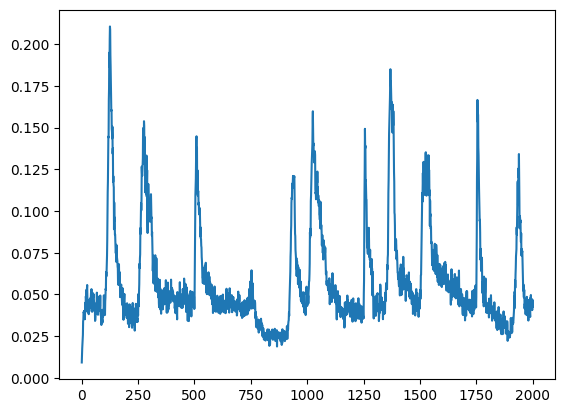

In [66]:
plt.plot(np.mean(allmetas[:,:,0],axis=0))

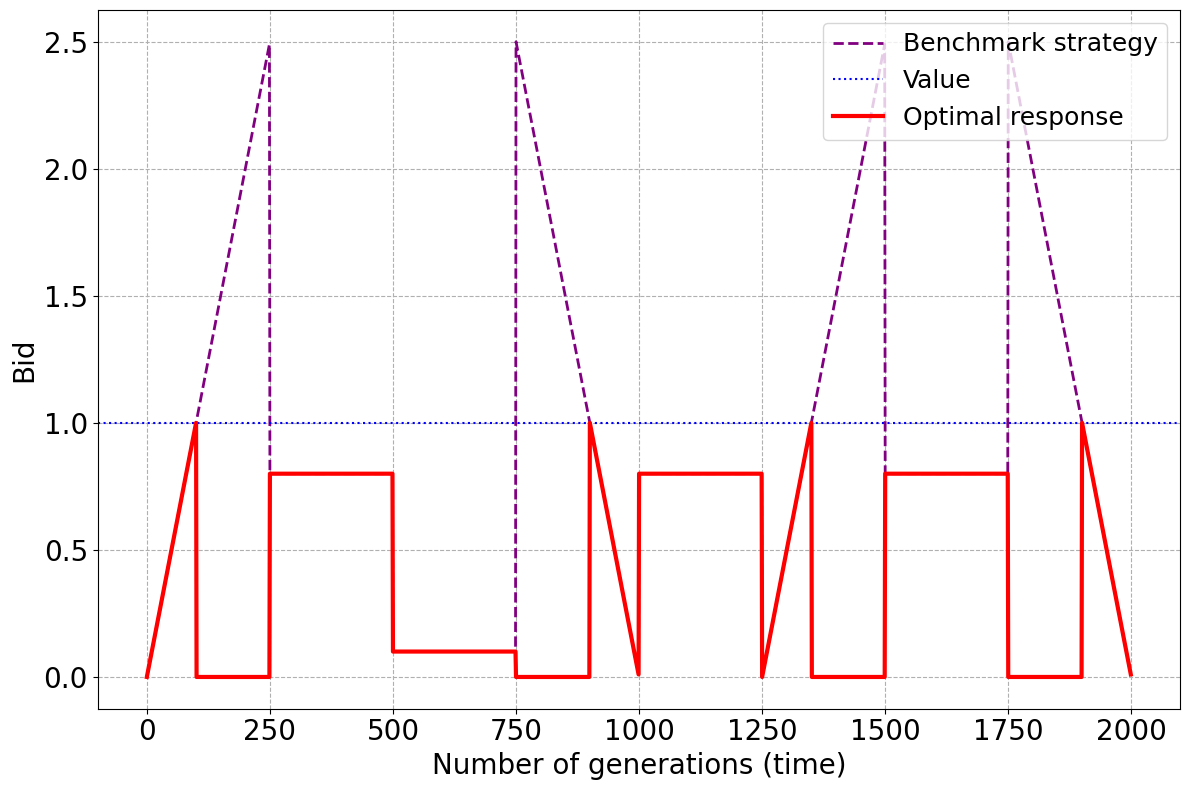

In [60]:
plt.figure(figsize=(12, 8))
plt.plot(mean_as2[0:2000], label="Benchmark strategy", linewidth=2, linestyle='--', color='purple')
plt.axhline(y=1, color='b', label = "Value", linestyle='dotted')
# Modify the optimals
optimals = mean_as2[0:2000].copy()  # Avoid modifying the original array
optimals[optimals > popevo.value] = 0
plt.plot(optimals, label="Optimal response", linewidth=3, linestyle='-', color='red')
plt.legend(loc="upper right", fontsize=18)
#plt.title("Benchmark bidding strategy vs optimal response", fontsize=16)
plt.xlabel("Number of generations (time)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Bid", fontsize=20)
plt.grid(True, linestyle="--")
plt.tight_layout()
plt.savefig("bmark_vs_optimals.pdf")

# Show the plot
plt.show()


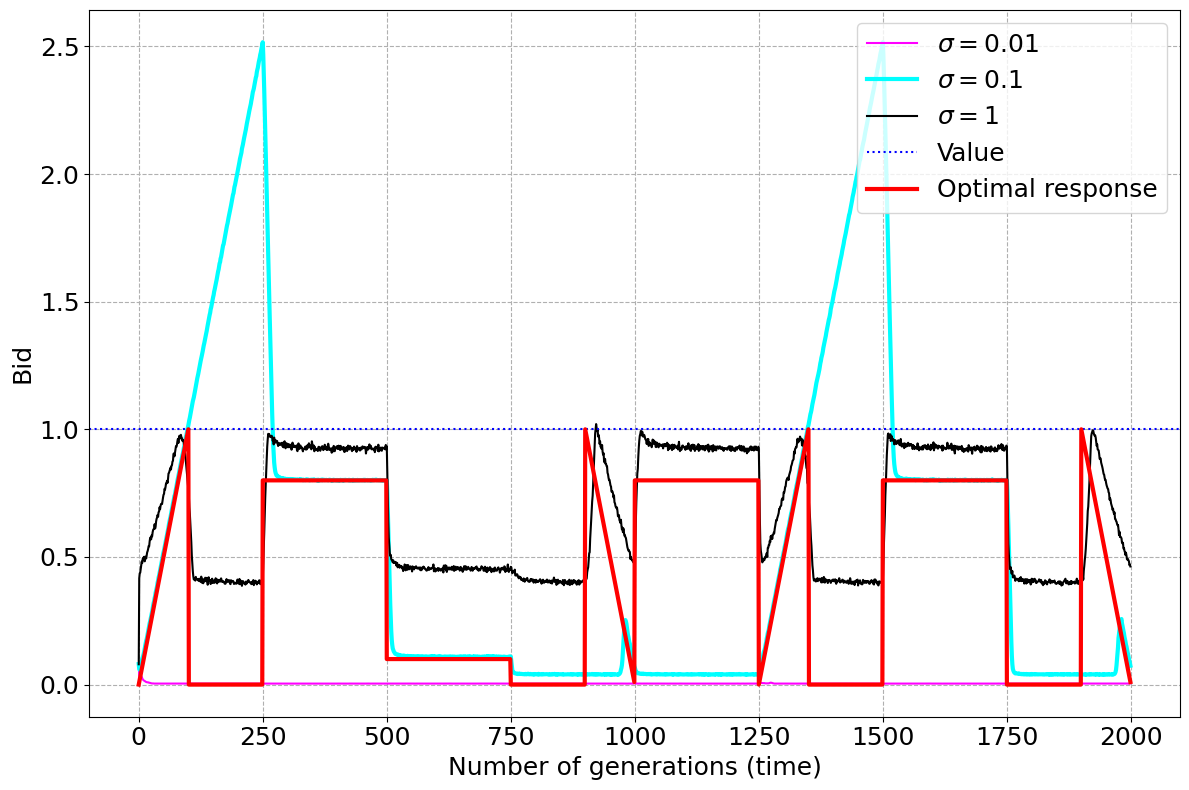

In [44]:
# Create a larger figure
plt.figure(figsize=(12, 8))

# Plot with adjusted line widths and styles
plt.plot(smean_as1[0:2000], label="$\sigma=0.01$", linestyle='-', color='magenta')
plt.plot(smean_as2[0:2000], label="$\sigma=0.1$", linestyle='-', linewidth=3, color='cyan')
plt.plot(smean_as3[0:2000], label="$\sigma=1$", linestyle='-', color='black')
#plt.plot(mean_as1_elite[0:2000], linewidth=4, label="mean_actions_elites", linestyle='--', color='g')
#plt.plot(mean_as2[0:2000], label="Benchmark strategy", linewidth=2, linestyle='--', color='purple')
plt.axhline(y=1, color='b', label = "Value", linestyle='dotted')

# Modify the optimals
optimals = mean_as2[0:2000].copy()  # Avoid modifying the original array
optimals[optimals > popevo.value] = 0
plt.plot(optimals, label="Optimal response", linewidth=3, linestyle='-', color='red')
#plt.plot(abs(mean_meta_1s[0:2000,0]), color="green")
#plt.plot(abs(mean_meta_1s[0:2000,1]), color="cyan")

# Add legend, grid, and labels
plt.legend(loc="upper right", fontsize=18)
#plt.title("Benchmark bidding strategy vs optimal response", fontsize=16)
plt.xlabel("Number of generations (time)", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel("Bid", fontsize=18)
plt.grid(True, linestyle="--")
plt.tight_layout()
plt.savefig("constant_mut2.pdf")

# Show the plot
plt.show()


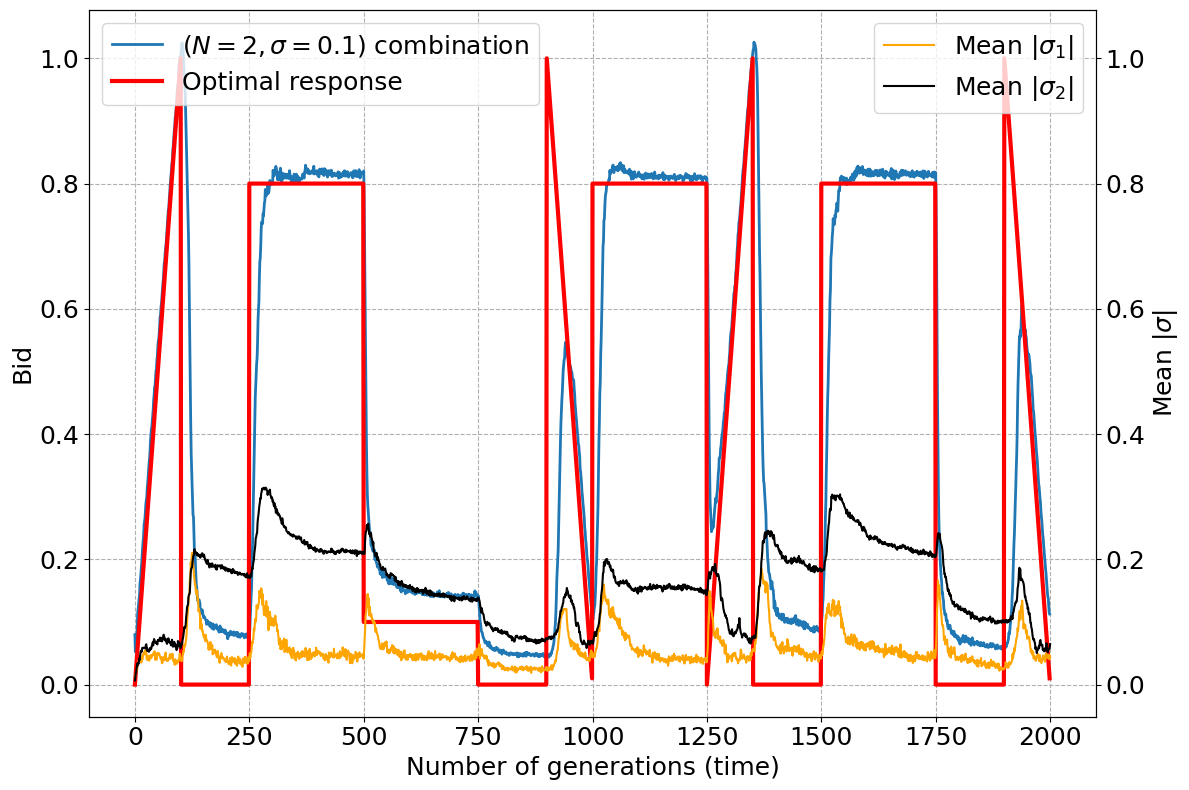

In [71]:
import matplotlib.pyplot as plt

# Create a larger figure
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot on the first y-axis (ax1)
ax1.plot(allsmean3[0:2000], label="$(N=2, \sigma=0.1)$ combination", linewidth=2, linestyle='-')
# ax1.plot(mean_as2[0:2000], label="$\sigma=0.1$", linestyle='-', linewidth=3, color='cyan')
# ax1.plot(mean_as3[0:2000], label="$\sigma=1$", linestyle='-', color='black')
# ax1.plot(mean_as1_elite[0:2000], linewidth=4, label="mean_actions_elites", linestyle='--', color='g')
# ax1.plot(mean_as2[0:2000], label="Benchmark strategy", linewidth=2, linestyle='--', color='purple')
#ax1.axhline(y=1, color='b', label="Value", linestyle='dotted')

# Modify the optimals
optimals = mean_as2[0:2000].copy()  # Avoid modifying the original array
optimals[optimals > popevo.value] = 0
ax1.plot(optimals, label="Optimal response", linewidth=3, linestyle='-', color='red')

# Set up labels and ticks for the first y-axis
ax1.set_xlabel("Number of generations (time)", fontsize=18)
ax1.set_ylabel("Bid", fontsize=18)
ax1.tick_params(axis='y', labelsize=18)
ax1.tick_params(axis='x', labelsize=18)
ax1.grid(True, linestyle="--")

# Add legend for ax1
ax1.legend(loc="upper left", fontsize=18)

# Create the second y-axis (ax2), sharing the x-axis but with its own y-axis
ax2 = ax1.twinx()

# Plot mean_meta_1s on the second y-axis
ax2.plot(np.mean(allmetas[:,:,0],axis=0), color="orange", label="Mean $|\sigma_1|$")
ax2.plot(np.mean(allmetas[:,:,1],axis=0), color="black", label="Mean $|\sigma_2|$")

# Set the same scale for both y-axes (if necessary)
ax2.set_ylim(ax1.get_ylim())  # Ensure both y-axes have the same limits

# Set labels and ticks for the second y-axis
ax2.set_ylabel("Mean $|\sigma|$", fontsize=18)
ax2.tick_params(axis='y', labelsize=18)

# Add legend for ax2
ax2.legend(loc="upper right", fontsize=18)

# Show the plot
plt.tight_layout()
plt.savefig("meta4.pdf")
plt.show()


In [4]:
for i in [0,1,2,3,4]:
    for j in [0.001,0.01,0.02,0.05,0.1,0.2,0.5,1.0,2.0]:
        popevo = PopulationEvolution(
            population_size = 100, 
            top_k = 50, 
            main_genotype_length = 1, 
            meta_level = i, 
            meta_initialization = 0.1, 
            meta_mutation_rate = j, 
            nr_of_generations = 2000, 
            referential = False, 
            elitism = True, 
            value = 1, 
            mutation_type = 1, 
            verbose = False)
        meta_mean_scores1 = []
        meta_std_scores1 = []
        for k in range(50):
            mean_scores1, mean_scores2, std_scores1, std_scores2, mean_as1, mean_as2, std_as1, std_as2, mean_meta_1s, std_meta_1s, mean_scores1_elite, std_scores1_elite, mean_as1_elite, std_as1_elite, mean_meta_1s_elite, std_meta_1s_elite = popevo.evolve()
            meta_mean_scores1.append(np.mean(mean_scores1))
            #meta_std_scores1.append(np.std(mean_scores1))
        print("meta_level: {}, mutation_rate: {}".format(i,j))
        print("Mean scores: {}, mean std: {}".format(np.mean(meta_mean_scores1), np.std(meta_mean_scores1)))

meta_level: 0, mutation_rate: 0.001
Mean scores: 0.0011150033937710917, mean std: 0.00010277974099421182
meta_level: 0, mutation_rate: 0.01
Mean scores: -0.0018786983907964868, mean std: 0.00020375080622518933
meta_level: 0, mutation_rate: 0.02
Mean scores: -0.19084835676512657, mean std: 0.00834979586505054
meta_level: 0, mutation_rate: 0.05
Mean scores: -0.12207815439723997, mean std: 0.0017321281941042733
meta_level: 0, mutation_rate: 0.1
Mean scores: -0.09646399901306464, mean std: 0.0014841431645806274
meta_level: 0, mutation_rate: 0.2
Mean scores: -0.08259681649143044, mean std: 0.0016343148275596053
meta_level: 0, mutation_rate: 0.5
Mean scores: 0.028658416015606855, mean std: 0.0006246701037056445
meta_level: 0, mutation_rate: 1.0
Mean scores: -0.0897280487822774, mean std: 0.0008486811066115357
meta_level: 0, mutation_rate: 2.0
Mean scores: -0.37951604765915753, mean std: 0.0015530197044161939
meta_level: 1, mutation_rate: 0.001
Mean scores: -0.14838860596744294, mean std: 0.0

In [29]:
'''
meta_level: 0, mutation_rate: 0.001
Mean scores: 0.0011608686337866467, mean elite scores: 0.0016041678471558774
meta_level: 0, mutation_rate: 0.01
Mean scores: -0.00180191577688254, mean elite scores: 0.00285444326871834
meta_level: 0, mutation_rate: 0.02
Mean scores: -0.18938233995765397, mean elite scores: -0.01991692068169402
meta_level: 0, mutation_rate: 0.05
Mean scores: -0.12230298187132667, mean elite scores: 0.059036971177689745
meta_level: 0, mutation_rate: 0.1
Mean scores: -0.09640337590632045, mean elite scores: 0.09028021780719911
meta_level: 0, mutation_rate: 0.2
Mean scores: -0.08289802044679345, mean elite scores: 0.11652599600931743
meta_level: 0, mutation_rate: 0.5
Mean scores: 0.028473989973032982, mean elite scores: 0.26180885365379025
meta_level: 0, mutation_rate: 1.0
Mean scores: -0.09004638848270345, mean elite scores: 0.25524870867684424
meta_level: 0, mutation_rate: 2.0
Mean scores: -0.3792908744982838, mean elite scores: 0.24221254232532372
meta_level: 1, mutation_rate: 0.001
Mean scores: -0.14643291494564986, mean elite scores: 0.03544351187979408
meta_level: 1, mutation_rate: 0.01
Mean scores: -0.11039093183776352, mean elite scores: 0.056417640043586605
meta_level: 1, mutation_rate: 0.02
Mean scores: -0.1063694674441212, mean elite scores: 0.07378726004155
meta_level: 1, mutation_rate: 0.05
Mean scores: -0.07665050250702159, mean elite scores: 0.1084499218316991
meta_level: 1, mutation_rate: 0.1
Mean scores: 0.030638579985331576, mean elite scores: 0.21025921587314733
meta_level: 1, mutation_rate: 0.2
Mean scores: 0.0766192856377671, mean elite scores: 0.26461204726656445
meta_level: 1, mutation_rate: 0.5
Mean scores: 0.023017487949328105, mean elite scores: 0.2661246369657948
meta_level: 1, mutation_rate: 1.0
Mean scores: -0.10032778334703008, mean elite scores: 0.2626040991816341
meta_level: 1, mutation_rate: 2.0
Mean scores: -0.38500737402371177, mean elite scores: 0.25512910218696333
meta_level: 2, mutation_rate: 0.001
Mean scores: -0.027778178720437946, mean elite scores: 0.01996836592700458
meta_level: 2, mutation_rate: 0.01
Mean scores: -0.07982548142935536, mean elite scores: 0.09233054884544892
meta_level: 2, mutation_rate: 0.02
Mean scores: -0.02420888221288465, mean elite scores: 0.16704633503058258
meta_level: 2, mutation_rate: 0.05
Mean scores: 0.06285880066187108, mean elite scores: 0.24212244757900803
meta_level: 2, mutation_rate: 0.1
Mean scores: 0.06326380029346965, mean elite scores: 0.26193548193409527
meta_level: 2, mutation_rate: 0.2
Mean scores: 0.043995057982084, mean elite scores: 0.26565286577135383
meta_level: 2, mutation_rate: 0.5
Mean scores: -0.039710844347691295, mean elite scores: 0.26494579248279787
meta_level: 2, mutation_rate: 1.0
Mean scores: -0.21036875074729125, mean elite scores: 0.2610480494906953
meta_level: 2, mutation_rate: 2.0
Mean scores: -0.6042340234896594, mean elite scores: 0.25474937842636936
meta_level: 3, mutation_rate: 0.001
Mean scores: 0.0627697359491354, mean elite scores: 0.24895767426047022
meta_level: 3, mutation_rate: 0.01
Mean scores: 0.04898877105336722, mean elite scores: 0.2501671556674455
meta_level: 3, mutation_rate: 0.02
Mean scores: 0.04444921689145133, mean elite scores: 0.2577936584854599
meta_level: 3, mutation_rate: 0.05
Mean scores: 0.028341389561281592, mean elite scores: 0.25545909122675414
meta_level: 3, mutation_rate: 0.1
Mean scores: -0.0496616593139281, mean elite scores: 0.25915117259195636
meta_level: 3, mutation_rate: 0.2
Mean scores: -0.24811820514400978, mean elite scores: 0.26026637136775166
meta_level: 3, mutation_rate: 0.5
Mean scores: -0.5419845931673539, mean elite scores: 0.25696310645969456
meta_level: 3, mutation_rate: 1.0
Mean scores: -0.7460706693020203, mean elite scores: 0.2537593098218792
meta_level: 3, mutation_rate: 2.0
Mean scores: -1.3956168107560007, mean elite scores: 0.24810298356273855
meta_level: 4, mutation_rate: 0.001
Mean scores: 0.016074030679389593, mean elite scores: 0.2616273870892623
meta_level: 4, mutation_rate: 0.01
Mean scores: -0.0036451796894161675, mean elite scores: 0.26311443437950127
meta_level: 4, mutation_rate: 0.02
Mean scores: -0.13599902276402104, mean elite scores: 0.261835271817237
meta_level: 4, mutation_rate: 0.05
Mean scores: -0.15654767492731628, mean elite scores: 0.2616317069348964
meta_level: 4, mutation_rate: 0.1
Mean scores: -1.9548603314401785, mean elite scores: 0.24371505793376652
meta_level: 4, mutation_rate: 0.2
Mean scores: -3.119559408170875, mean elite scores: 0.24000678788809876
meta_level: 4, mutation_rate: 0.5
Mean scores: -25.12406477699975, mean elite scores: 0.16834955813340366
meta_level: 4, mutation_rate: 1.0
Mean scores: -4.819171550771848, mean elite scores: 0.22379978172459492
meta_level: 4, mutation_rate: 2.0
Mean scores: -27.918786717924508, mean elite scores: 0.15943261837256112
'''

'\nmeta_level: 0, mutation_rate: 0.001\nMean scores: 0.0011608686337866467, mean elite scores: 0.0016041678471558774\nmeta_level: 0, mutation_rate: 0.01\nMean scores: -0.00180191577688254, mean elite scores: 0.00285444326871834\nmeta_level: 0, mutation_rate: 0.02\nMean scores: -0.18938233995765397, mean elite scores: -0.01991692068169402\nmeta_level: 0, mutation_rate: 0.05\nMean scores: -0.12230298187132667, mean elite scores: 0.059036971177689745\nmeta_level: 0, mutation_rate: 0.1\nMean scores: -0.09640337590632045, mean elite scores: 0.09028021780719911\nmeta_level: 0, mutation_rate: 0.2\nMean scores: -0.08289802044679345, mean elite scores: 0.11652599600931743\nmeta_level: 0, mutation_rate: 0.5\nMean scores: 0.028473989973032982, mean elite scores: 0.26180885365379025\nmeta_level: 0, mutation_rate: 1.0\nMean scores: -0.09004638848270345, mean elite scores: 0.25524870867684424\nmeta_level: 0, mutation_rate: 2.0\nMean scores: -0.3792908744982838, mean elite scores: 0.24221254232532372

In [29]:
np.mean(mean_scores1)

0.07693193373269185